# Introduction

This labelled dataset was compiled by [Wei-Ta Chu and Hung-Jui Guo](https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html).
The genres are classified divided according to IMDb. Employment of deep learning frameworks as we are dealing with images. 

# Executive Summary

**Nature of the problem:**
Multi-label Classification  
**Problem Statement:**
Are we able to predict the labelled set of unseen posters through analysing training instances with a known labelled set?  
**Dataset:**
Labelled genre movie poster dataset with respective images from Wei-Ta Chu and Hung-Jui Guo
Total of 23 genres with 552 permutations (193 of which is unique)

# Table of Contents

<ul>
<li><a href="#intro">i) Explore Dataset</a></li>
<li><a href="#eda">ii) EDA</a></li>    
<li><a href="#preprocessing">iii) Data Preprocessing</a></li>
<li><a href="#modelling">iv) Modelling</a></li>
<li><a href="#predict">v) Predictions on Test and Unseen Images</a></li>
<li><a href="#evaluate">vi) Model Evaluation</a></li>    
<li><a href="#conclusions">vii) Conclusions</a></li>
<li><a href="#references">viii) References</a></li>
</ul>

<a id='intro'></a>
# Explore Dataset

## Import Dependencies

In [220]:
# Data manipulation
import pandas as pd
import numpy as np

## Image processing
# import skimage

# Data preprocessing
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split

# Modelling
import keras 
import keras.backend as K
from keras.callbacks import TensorBoard
from keras import optimizers
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

# Transfer Learning
from keras.applications import MobileNet, VGG16

# Model Evaluation
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import hamming_loss, label_ranking_loss, average_precision_score 

# Plotting & Data visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pre-configure Plotting Style 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
%config InlineBackend.figure_format = 'retina'

# Miscellaneous
import os
import time
import random
import itertools 
from tqdm import tqdm
from collections import Counter

## Read Dataset

In [2]:
# Load data set
train = pd.read_csv('./dataset/train.csv')

In [3]:
# Check dimensionality of dataset
train.shape

(7242, 27)

In [4]:
# Preview data
train.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# List Features
for i,v in enumerate(train):
    print(i, v)

0 Id
1 Genre
2 Action
3 Adventure
4 Animation
5 Biography
6 Comedy
7 Crime
8 Documentary
9 Drama
10 Family
11 Fantasy
12 History
13 Horror
14 Music
15 Musical
16 Mystery
17 N/A
18 News
19 Reality-TV
20 Romance
21 Sci-Fi
22 Short
23 Sport
24 Thriller
25 War
26 Western


In [6]:
print('Total no. of genres: {}'.format(len(train.columns[2:])))
print('Total no. of posters/images: {}'.format(train.Id.nunique()))
print('Total no. of genre permutations: {}'.format(train.Genre.nunique()))

Total no. of genres: 25
Total no. of posters/images: 7231
Total no. of genre permutations: 552


In [7]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
N/A               0
Reality-TV        0
dtype: object

## Data Cleaning

To drop rows containing N/A and Reality-TV leaving us with 23 genres as the 'N/A' and 'Reality-TV' are under-represented

In [8]:
# Drop N/A rows
na_rows = train[train.Genre.str.contains('N/A') == True].index
train = train.drop(na_rows, axis=0)

# Reality-TV rows
rt_rows = train[train.Genre.str.contains('Reality-TV') == True].index
train = train.drop(rt_rows, axis=0)

In [9]:
# Drop N/A, Reality-TV columns
train.drop(columns=['N/A','Reality-TV'], inplace=True)

# Reset index
train.reset_index(drop=True, inplace=True)

**Dropped the following 13 rows (also removed on original datset):**

- `N/A`
    - 3304    tt0116748
    - 3312    tt0289456
    - 3531    tt0282965
    - 3783    tt0322650
    - 4029    tt0402398
    - 4635    tt0468580
    - 4870    tt2546300
    - 5174    tt2546294
    - 5175    tt2546294
    - 7192    tt3521442
  
  
- `Reality-TV`
    - 4544    tt0808142
    - 6870    tt2884170

In [10]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False)

Drama          3619
Comedy         2900
Action         1343
Romance        1334
Crime          1176
Thriller        918
Adventure       870
Documentary     652
Horror          503
Fantasy         467
Mystery         454
Biography       441
Family          434
Sci-Fi          399
Music           305
Animation       244
History         224
Sport           221
War             144
Musical          97
Western          50
Short            45
News             21
dtype: object

`N/A` and `Reality-TV` genres have been removed

<a id='eda'></a>
## EDA

### Convert Images to Array

In [11]:
# Read in images 
train_images = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('dataset/images/'+ train['Id'][i]+'.jpg', target_size=(250, 200, 3))
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

100%|██████████| 7242/7242 [00:23<00:00, 311.33it/s]


### Display Movie Posters

Genre of Movie Poster 1: ['Action', 'Crime', 'Drama'] 
Genre of Movie Poster 2: ['Adventure', 'Comedy', 'Family']


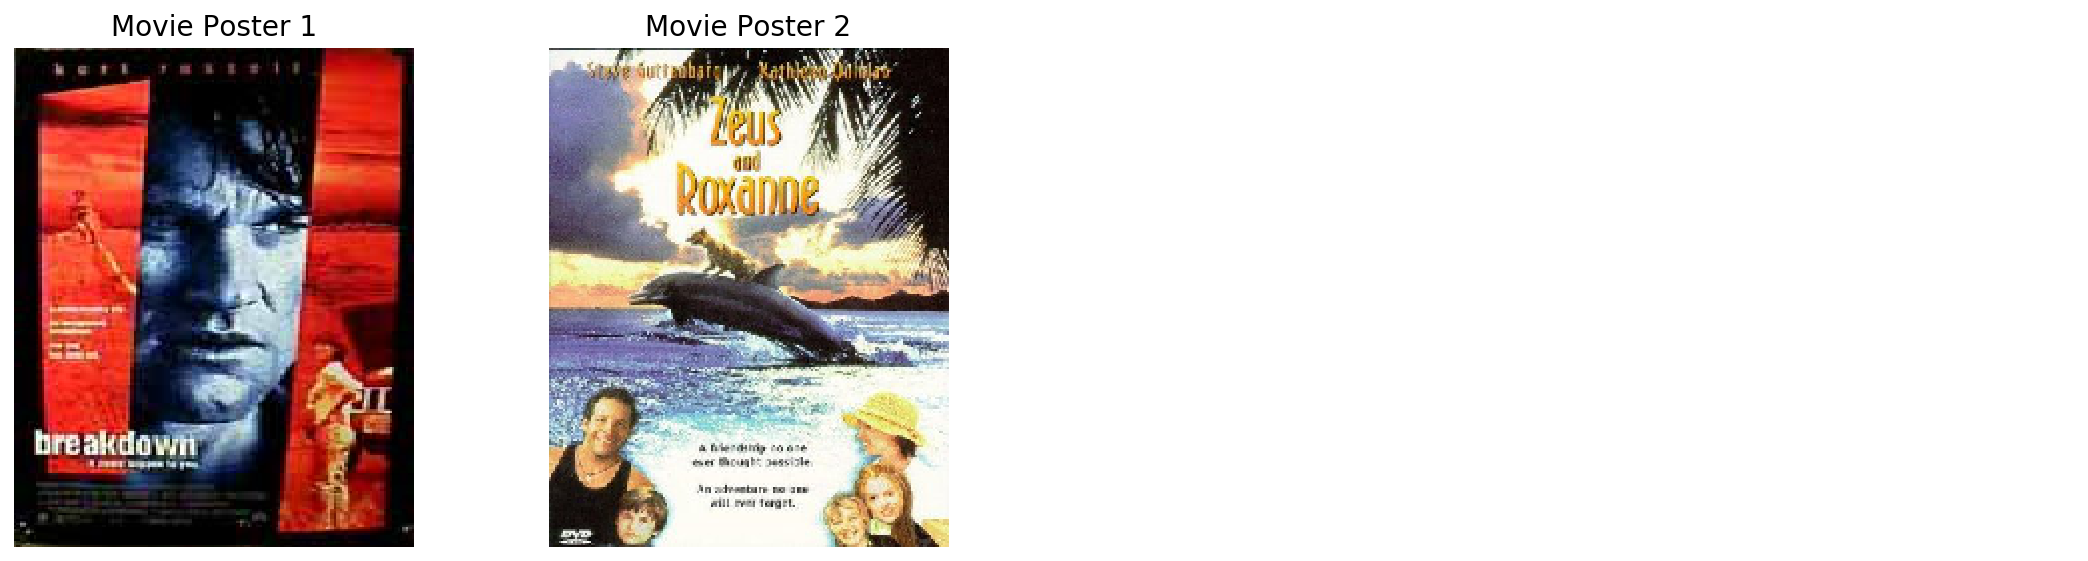

In [13]:
# Create a generator for random indexes
poster_index = list(range(7243))
rand_index = random.sample(poster_index, 2)

# Select random posters
poster_1, poster_2 = train_images[rand_index[0]], train_images[rand_index[1]]

# Display movie poster and title
fig, ax = plt.subplots(ncols = 4, figsize=(15, 4))
ax[0].imshow(poster_1)
ax[1].imshow(poster_2)
ax[0].set_title('Movie Poster 1', fontsize=14)
ax[1].set_title('Movie Poster 2', fontsize=14)

# Remove axes
for ax in ax:
    ax.axis('off')    
plt.tight_layout()

print('Genre of Movie Poster 1: {} \nGenre of Movie Poster 2: {}'.format(train['Genre'][rand_index[0]], train['Genre'][rand_index[1]]))

Sample of movie posters in the dataset

### Genre Counts

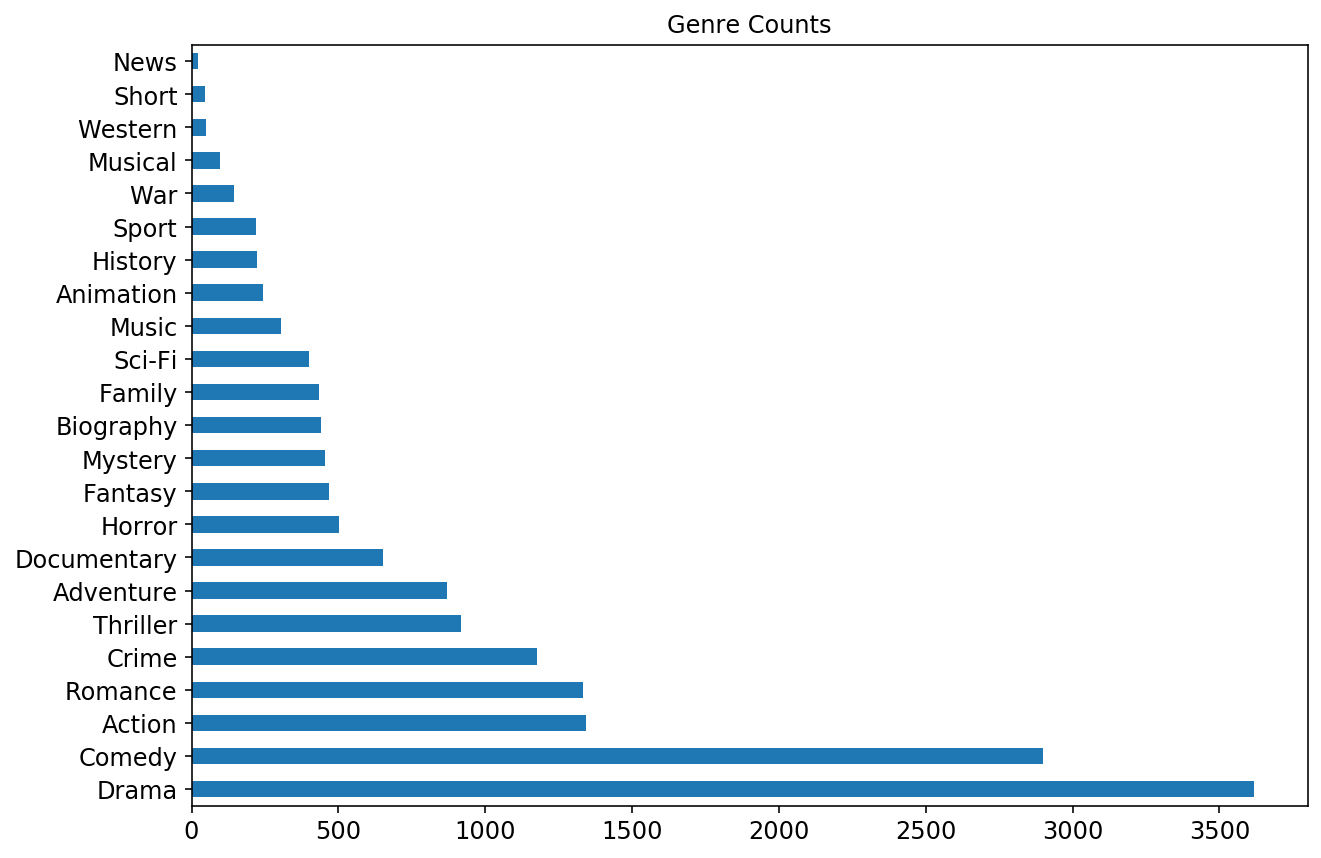

In [14]:
# Total counts per genre
train.sum()[2:].sort_values(ascending=False).plot(kind='barh', figsize=(10,7))
plt.title('Genre Counts');

We can see from this distribution of the movie poster data set that most movies have `Drama` as one of its labels. We foresee that our model might overfit on the `Drama` genre. This will affect every new image, since the model might predict the `Drama` genre even though in actuality is not.

### Mutli-label Counts

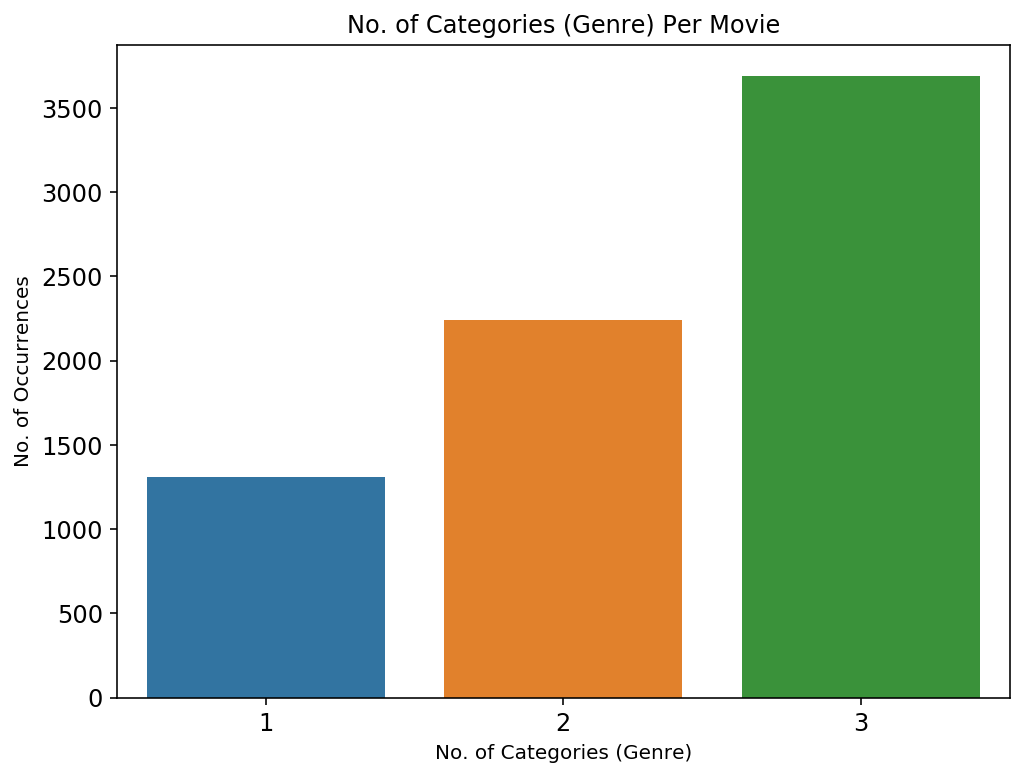

In [128]:
# Movies with multilabels
row_sum = train.iloc[:, 2:].sum(axis=1)
x = row_sum.value_counts()

# Plot barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(x.index, x.values)
plt.title("No. of Categories (Genre) Per Movie", fontsize=12)
plt.ylabel('No. of Occurrences')
plt.xlabel('No. of Categories (Genre)');

From the graph above, we see that there is minimum of 1 genre per movie, and a maximum of 3 genres per movie.

### Unique Multi-label Classifications

In [16]:
# Identify permutation of Genres that appear only once
df_unique = train[train['Genre'].map(train['Genre'].value_counts()) < 2]

In [18]:
# Permutations of Genres that appear only once
len(df_unique.Genre.unique().tolist())

193

There is a total of 193 unique genre combinations. Meaning 193 permutations of genres appear only once.
This can range from 1 to 3 number of categories.

<a id='preprocessing'></a>
# Date Preprocessing

## Set up X and y

In [19]:
X = np.array(train_images)
y = np.array(train.drop(columns=['Id', 'Genre']))

## Train/Test Split (with Iterative Stratification)

In [18]:
# mskf = MultilabelStratifiedKFold(n_splits=2, random_state=42)

# for train_index, test_index in mskf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

## Train/Test Split

In [20]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =0.2)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5793, 250, 200, 3), (1449, 250, 200, 3), (5793, 23), (1449, 23))

**Have to fix this:**
*The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2*

**To rectify this:**
Use ``from skmultilearn.model_selection import iterative_train_test_split`` for a more balanced split for multi-label problems or ``from iterstrat.ml_stratifiers import MultilabelStratifiedKFold`` for itertaive stratification

<a id='modelling'></a>
# Modelling

### Learning Curve Plot Function

In [62]:
# Function for plotting learning curves
def plot_curve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['acc'])
    plt.plot(epoch_range, history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
  
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print('Mean Training Accuracy: ', round(np.mean(history.history['acc']), 3), '\nMean Testing Accuracy: ', round(np.mean(history.history['val_acc']), 3))
    print('Mean Training Loss: ', round(np.mean(history.history['loss']), 3), '\nMean Testing Loss: ', round(np.mean(history.history['val_loss']), 3))

## VGG16 Model

In [24]:
# Create the base pre-trained model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 200, 3))

# Add a global spatial average pooling layer
x = vgg_model.output

# Adaptive Pooling
x = GlobalAveragePooling2D()(x) 

# Add fully-connected layers
x = Dense(64, activation='relu')(x)

# Add final fully-connected layer
predictions = Dense(23, activation='sigmoid')(x)

# this is the model we will train
vgg_model = Model(inputs=vgg_model.input, outputs=predictions)
len(vgg_model.layers)

22

In [32]:
# Using Adam optimser with a learning rate of 0.01
optimizer = Adam(lr=0.01)

# Compile the model (should be done *after* setting layers to non-trainable)
vgg_model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

# Train model
vgg_history = vgg_model.fit(X_train, y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=10)

## CNN Model

We want to penalize each output node independently. So I picked a binary loss and model the output of the network as a independent Bernoulli distributions per label.

In [48]:
NAME = 'cnn-sig-bin-{}'.format(int(time.time()))
                               
tbCallback = TensorBoard(log_dir='logs/{}'.format(NAME))                        

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape =(250,200,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(23, activation='sigmoid'))

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 248, 198, 16)      448       
_________________________________________________________________
batch_normalization_19 (Batc (None, 248, 198, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 124, 99, 16)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 124, 99, 16)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 122, 97, 32)       4640      
_________________________________________________________________
batch_normalization_20 (Batc (None, 122, 97, 32)       128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 61, 48, 32)       

We choose `sigmoid` because it allows the model to output a number between 0 and 1 for each label independently. This number indicates the probability that the corresponding attribute is present in the image.

In [50]:
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc'])

In [51]:
history = model.fit(X_train, y_train, 
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    epochs=35,
                    callbacks=[tbCallback])

Train on 5793 samples, validate on 1449 samples
Epoch 1/35
5793/5793 [==============================] - 236s 41ms/step - loss: 0.7157 - acc: 0.6305 - val_loss: 1.3171 - val_acc: 0.4267
Epoch 2/35
5793/5793 [==============================] - 229s 40ms/step - loss: 0.3408 - acc: 0.8781 - val_loss: 0.5238 - val_acc: 0.7873
Epoch 3/35
5793/5793 [==============================] - 235s 41ms/step - loss: 0.2822 - acc: 0.8996 - val_loss: 0.6854 - val_acc: 0.7715
Epoch 4/35
5793/5793 [==============================] - 232s 40ms/step - loss: 0.2707 - acc: 0.9024 - val_loss: 0.9107 - val_acc: 0.7678
Epoch 5/35
5793/5793 [==============================] - 233s 40ms/step - loss: 0.2661 - acc: 0.9042 - val_loss: 0.4024 - val_acc: 0.8750
Epoch 6/35
5793/5793 [==============================] - 233s 40ms/step - loss: 0.2627 - acc: 0.9052 - val_loss: 0.3471 - val_acc: 0.8861
Epoch 7/35
5793/5793 [==============================] - 233s 40ms/step - loss: 0.2590 - acc: 0.9064 - val_loss: 0.3347 - val_acc: 

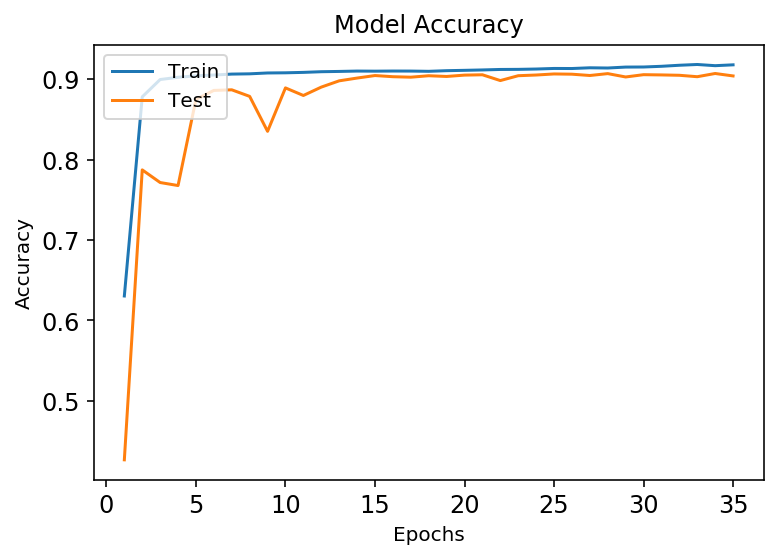

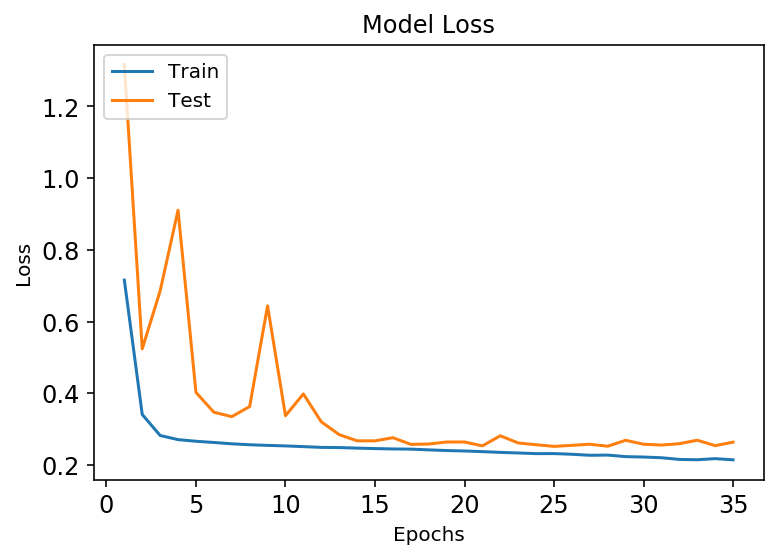

Mean Training Accuracy:  0.902 
Mean Testing Accuracy:  0.873
Mean Training Loss:  0.257 
Mean Testing Loss:  0.361


In [63]:
plot_curve(history, 35)

<a id='predict'></a>
# Predictions on Test & Unseen Images

## CNN Model Predictions on Test Images

In [166]:
# Create function for predicting test/unseen images & displaying results of prediction
def prediction(img_filepath, target_size=(250, 200, 3)):
    new_img = image.load_img(img_filepath, target_size=target_size)
    new_img = image.img_to_array(new_img) / 255
    
    classes = np.array(train.columns[2:])
    proba = model.predict(new_img.reshape(1,250,200,3))
    top_4 = np.argsort(proba[0])[:-5:-1]
    
    print('Genre Predictions:')
    for i in range(4):
        print('{}'.format(classes[top_4[i]])+' ({:.3})'.format(proba[0][top_4[i]]))
    plt.axis('off')
    plt.imshow(new_img)

### CNN Model Predictions on Test Image 01

Genre Predictions:
Drama (0.704)
Comedy (0.372)
Romance (0.259)
Crime (0.134)


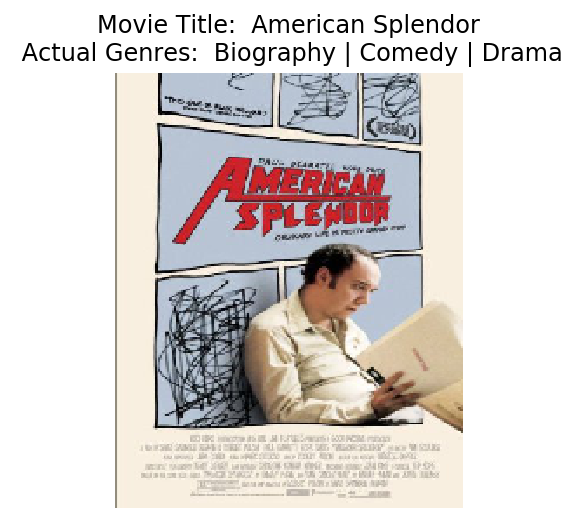

In [168]:
test_img = image.array_to_img(X_test[150])
plt.imshow(test_img)
plt.title('Movie Title:  American Splendor\n Actual Genres:  Biography | Comedy | Drama');
plt.axis('off')

prediction('dataset/images/tt0305206.jpg')

### CNN Model Predictions on Test Image 02

Genre Predictions:
Drama (0.536)
Thriller (0.271)
Action (0.233)
Crime (0.224)


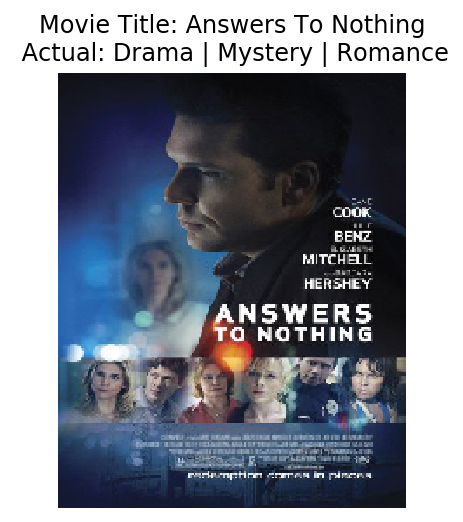

In [180]:
test_img_2 = image.array_to_img(X_test[555])
plt.imshow(test_img_2)
plt.axis('off')
plt.title('Movie Title: Answers To Nothing\n Actual: Drama | Mystery | Romance');
prediction('dataset/images/tt1523939.jpg')

### CNN Model Predictions on Test Image 03

Genre Predictions:
Action (0.581)
Thriller (0.357)
Drama (0.289)
Sci-Fi (0.224)


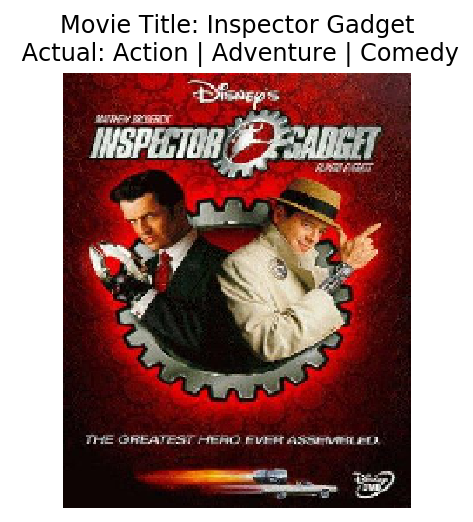

In [187]:
test_img_3 = image.array_to_img(X_test[800])
plt.imshow(test_img_3)
plt.axis('off')
plt.title('Movie Title: Inspector Gadget\n Actual: Action | Adventure | Comedy')
prediction('dataset/images/tt0141369.jpg')

### CNN Model Predictions on Test Image 04

Genre Predictions:
Horror (0.379)
Drama (0.272)
Thriller (0.268)
Documentary (0.243)


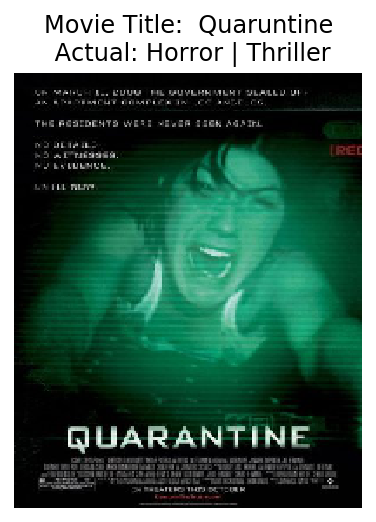

In [209]:
test_img_4 = image.array_to_img(X_test[1400])
plt.imshow(test_img_4)
plt.axis('off')
plt.title('Movie Title:  Quaruntine\n Actual: Horror | Thriller')
prediction('dataset/images/tt1082868.jpg')

The model performed decently on testing images have predicted **at least 1 out of 3 genres** for every of the random test images. Below we will use some important multi-label classification measures to have a better scientific approach in determining the accuracy of the ConvNet.

## CNN Model Predictions on Unseen Images

Genre Predictions:
Drama (0.473)
Thriller (0.249)
Horror (0.242)
Action (0.151)


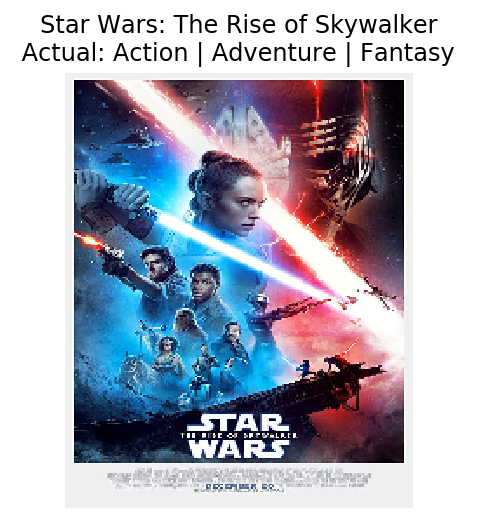

In [192]:
prediction('dataset/new_images/tt2527338.jpg')
plt.title('Star Wars: The Rise of Skywalker\n Actual: Action | Adventure | Fantasy ');

Genre Predictions:
Drama (0.616)
Action (0.437)
Crime (0.406)
Thriller (0.297)


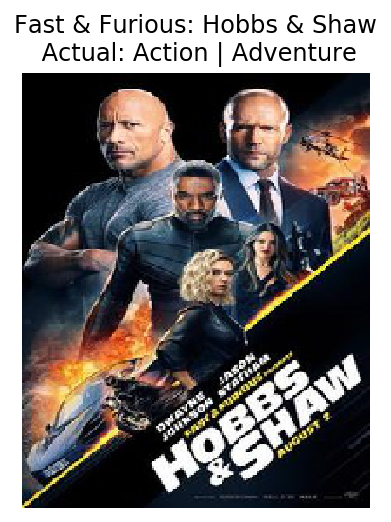

In [194]:
prediction('dataset/new_images/tt6806448.jpg')
plt.title('Fast & Furious: Hobbs & Shaw\n Actual: Action | Adventure');

Genre Predictions:
Drama (0.663)
Comedy (0.359)
Romance (0.336)
Thriller (0.129)


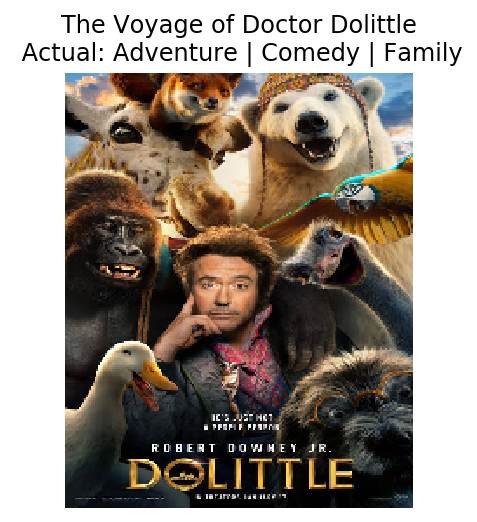

In [204]:
prediction('dataset/new_images/tt6673612.jpg')
plt.title('The Voyage of Doctor Dolittle\n Actual: Adventure | Comedy | Family');

Genre Predictions:
Drama (0.733)
Thriller (0.34)
Crime (0.21)
Mystery (0.175)


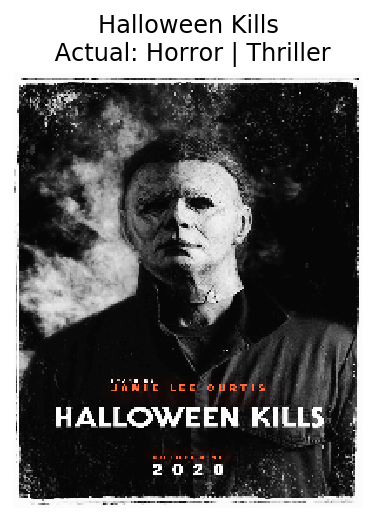

In [207]:
prediction('dataset/new_images/tt10665338.jpg')
plt.title('Halloween Kills\n Actual: Horror | Thriller');

From the predictions we are able to see that the model is performing decently having been able to detect elements of `Sci-fi` in the Star Wars poster as well as `Comedy` in Fast & Furious: Hobbs & Shaw.
While also predicting `Action` & `Adventure` for both. 

The limitations is due the dataset having too many `Drama` images and hence, is always being included in the predictions even though [Fast & Furious: Hobbs & Shaw.](https://www.imdb.com/title/tt6806448/)'s genres are just officially labelled as `Action` & `Adventure`. Intrestingly, there are certainly some elements of `Crime` in the movie's plot, however, it was not included as a label according to IMDb.

While [Star Wars: The Rise of Skywalker](https://www.imdb.com/title/tt2527338/?ref_=fn_al_tt_4) is officially labelled as `Action`,`Adventure`,`Fantasy`, and unfortunately the model was not able to predict this accurately.

Lastly, for [The Voyage of Doctor Dolittle](https://www.imdb.com/title/tt6673612/) it is labelled as `Adventure`, `Comdey`, `Family` film, and we can see that only the `Comedy` element was picked up by the model. 

<a id='evaluate'></a>
# Model Evaluations

To evaluate our model performance we will be using the following metrics for evaluation:

    - Hamming Loss (incorrect label assignment)
    - Avg. Precision Score (average fraction of relevant labels ranked higher than one other relevant labels)
    - Ranking Loss (incorrect order of rank values)

## Multi-label Confusion Matrix

In [72]:
preds = model.predict(X_test)
preds = preds.argmax(axis=-1)

In [81]:
test_labels = y_test.argmax(axis=-1)

In [87]:
matrix = multilabel_confusion_matrix(test_labels, preds)
print(matrix)

[[[1164   15]
  [ 249   21]]

 [[1340    3]
  [ 102    4]]

 [[1432    0]
  [  17    0]]

 [[1371    0]
  [  78    0]]

 [[ 935   59]
  [ 374   81]]

 [[1357    3]
  [  89    0]]

 [[1338   14]
  [  94    3]]

 [[ 220  951]
  [  15  263]]

 [[1447    0]
  [   2    0]]

 [[1440    0]
  [   9    0]]

 [[1448    0]
  [   1    0]]

 [[1408    9]
  [  29    3]]

 [[1448    0]
  [   1    0]]

 [[1447    0]
  [   2    0]]

 [[1446    1]
  [   2    0]]

 [[1448    0]
  [   1    0]]

 [[1447    0]
  [   2    0]]

 [[1424   19]
  [   6    0]]

 [[1448    0]
  [   1    0]]]


In [85]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.58      0.08      0.14       270
           1       0.57      0.04      0.07       106
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        78
           4       0.58      0.18      0.27       455
           5       0.00      0.00      0.00        89
           6       0.18      0.03      0.05        97
           7       0.22      0.95      0.35       278
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         1
          11       0.25      0.09      0.14        32
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          20       0.00    

To be ignored, as these are not final in evaluation

## Hamming Loss
The fraction of misclassified labels

In [125]:
h_loss = hamming_loss(test_labels, preds)
print('Hamming Loss: {}'.format(round(h_loss, 3)))

Hamming Loss: 0.741


## Average Precision Score
The average fraction of relevant labels ranked higher than one other relevant label

In [221]:
y_pred_proba = model.predict(X_test)
ap_score = average_precision_score(y_test, y_pred_proba)
print('Avg. Precision Score: {}'.format(round(ap_score, 3)))

Avg. Precision Score: 0.191


## Ranking Loss
Rank loss imposes a penalty on a classifier when a pair
of labels is incorrectly ranked.

In [121]:
#y_pred_proba = model.predict(X_test)
ranking_loss = label_ranking_loss(y_test, y_pred_proba)
print('Ranking Loss: {}'.format(round(ranking_loss, 3)))

Ranking Loss: 0.174


<a id='conclusions'></a>
# Conclusions

**Limitations:**
- The main challenge was data imbalance
- Collecting more poster data for under-represented genres will not solve this issue
- Subjective movie labelling by IMDb sources & varied posters for release
- Limited packages to deal with multi-label classification problems i.e iterative stratification for splitting data effectively, one-error loss etc.


**Learnings:**
- Transfer learning proved to be of little value in this multi-label problem. A ConvNet was our model of choice in achieving a high model accuracy (0.9) as compared to VGG16 (0.6)
- The activation and loss functions, Sigmoid & Binary Cross-entropy respectively were crucial in pushing the model's predictions in the right direction. In my experimenting on Colab, I tried numerous combinations like Softmax and Categorical Cross-entropy which achieved maximum accuracy score of 0.4
- Having a small batch-size of 32 as compared to 64 or 128 also improved model scores
- After 50 or more epochs, there was little progress in decrease in loss
- The main multi-label classification evaluation metrics are Hamming Loss, Ranking Loss, One-error (which there was no functions for), hence, to produce more angles on final evaluation, I have chosen Average Precision as another metric
- Hamming Loss score of 7/10 indicates that for every 10 classifications, we only have 3 correct. So on average, 1 out of 3 movies are predicted rightly (assuming every movie has 3 genres)
- Average Precision looks at the entire rankings predicted across the 23 genres. And having a score of close to 20% across 552 permutations of genres, proves to be rather encoruaging
- Ranking Loss looks at how the expectation of the mis-rank rate over all possible pairs of labels, which had a mis-rank rate of 0.2 for possible pairs. Which is good, but has it's limitations since some movies 1 genre, or 3.



**Next Steps:**
- Conduct SMOTE to severely under/over sample the majority/minority class to create a large number of distinct training sets to increase performance 
- Employ iterative stratification of train and test
- Further explore interpretability of the ConvNet
- Deepen understanding of inner workings of the ConvNet


<a id='references'></a>
# References

- *IMDb*, ["Movie Database"](https://www.imdb.com/)

- *Wei-Ta Chu and Hung-Jui Guo*, [“Movie Genre Classification based on Poster Images with Deep Neural Networks,” Proceedings of International Workshop on Multimodal Understanding of Social, Affective and Subjective Attributes, pp. 39-45, 2017. (in conjunction with ACM Multimedia 2017)](https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html)

- *Pulkit Sharma*, ["Your First Multi-label Image Classficiation"](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/)

- *Piotr Szymanski and Tomasz Kajdanowicz*, ["A Network Perspective on Stratification of Multi-Label Data"](http://proceedings.mlr.press/v74/szyma%C5%84ski17a/szyma%C5%84ski17a.pdf)

- *Rafał Grodzicki,  Jacek Mańdziuk, and Lipo Wang*, ["Improved Multilabel Classification with Neural Networks"](https://www.ntu.edu.sg/home/elpwang/PDF_web/08_PPSN.pdf)

- *Xi-Zhu Wu, Zhi-Hua Zhou*, ["A Unified View of Multi-Label Performance Measures"](http://proceedings.mlr.press/v70/wu17a/wu17a.pdf)

- *Victor Lavrenko*, ["Evaluation 12: mean average precision"](https://www.youtube.com/watch?v=pM6DJ0ZZee0)

- *Peltarion* ["Modeling View"](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy)

- *Apil Tamang*, [CNN Image](https://medium.com/@apiltamang/a-gentle-dive-into-the-anatomy-of-a-convolution-layer-6f1024339aca)

- *Daniel Godoy*, [Binary Cross-entropy Image](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)